The goal this project is to build and train a regression model on the Capital Bike Share (Washington, D.C.) 
Dataset can be found in kaggle on in this same folder
The steps:
1. split the data into a training and validation set (or apply cross validation)
2. conduct an exploratory data analysis
3. train a regression model
4. iteratively optimize the model by expanding or selecting features
5. regularize the model to avoid overfitting
6. calculate a RMSLE for the training and validation set


In [1]:
#import Library

#General lib
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

#Data preprocessing lib
from sklearn import preprocessing as prep
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#model lib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

#model evaluation lib
from sklearn.metrics import mean_squared_log_error

#lib to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import data
df_all = pd.read_csv('./data/train.csv', sep=',', index_col='datetime', parse_dates=True)
df_all.head()


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
#general information on dataset
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [4]:
#check for null in dataset
df_all.isnull().any().any()

False

General feature engineering that cannot lead to data leakgae will be done before splitting dataset into train and test data

In [5]:
#function to add new features to df
def set_datemonthTime(df):
    df['month'] = df.index.month
    df['weekday'] = df.index.day
    df['hour'] = df.index.hour
    return df

In [6]:
#function to change feature datatypes
def col_cat(df):
    cat_cols=['season','holiday','workingday','weather', 'hour', 'weekday','month']
    for col in cat_cols:
        df[col] = df[col].astype('category')
    return df

In [7]:
#function to drop features in df
def col_rem(df):
    df = df.drop(columns=['casual', 'registered', 'atemp'])
    return df


In [8]:
#run functions on df
df_all=set_datemonthTime(df_all)
df_all=col_cat(df_all)
df_all=col_rem(df_all)

df_all.shape

(10886, 11)

1. Split Data into train and Testset

In [9]:
##split dataset into X and y
X= df_all.drop(columns=['count'])
y=df_all['count']

In [10]:
###split data into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=42)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((8164, 10), (2722, 10), (8164,), (2722,))

2. Explorative Data Analysis

In [11]:
#check if there is na in the data
print(Xtrain.isnull().any().any())
print(Xtest.isnull().any().any())

False
False


In [12]:
Xtrain.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,month,weekday,hour
datetime,,,,,,,,,,
2011-07-11 00:00:00,3,0,1,1,28.70,65,12.9980,7,11,0
2012-05-18 22:00:00,2,0,1,1,22.96,52,22.0028,5,18,22
2011-04-01 23:00:00,2,0,1,1,12.30,61,6.0032,4,1,23
2012-09-16 09:00:00,3,0,0,1,23.78,60,8.9981,9,16,9
2011-02-01 23:00:00,1,0,1,3,8.20,93,12.9980,2,1,23


Examine the correlation between data

<AxesSubplot:>

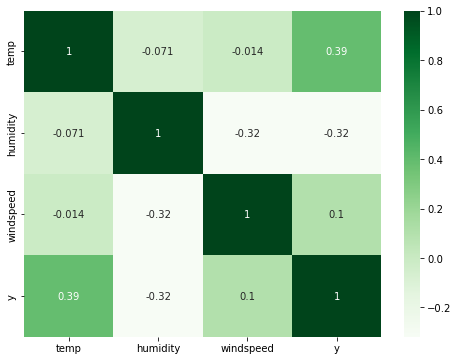

In [13]:
ax = plt.figure(figsize=(8,6))
Xy_train = Xtrain.join(ytrain.rename('y'))

pearsoncorr = Xy_train.corr(method='pearson')
sns.heatmap(pearsoncorr, xticklabels = pearsoncorr.columns, yticklabels=pearsoncorr.columns,
            cmap = 'Greens', annot=True)

Feature Engineering

In [14]:
###factorize the cartegoriacl features
Xtrain=pd.get_dummies(Xtrain, prefix=['season','holiday','workingday','weather', 'hour','weekday', 'month'], prefix_sep= '_', drop_first=True)
Xtest=pd.get_dummies(Xtest, prefix=['season','holiday','workingday','weather', 'hour','weekday', 'month'], prefix_sep= '_', drop_first=True,)

Xtrain.shape, Xtest.shape

((8164, 63), (2722, 63))

In [15]:
numeric_features = ['humidity','windspeed','temp']
numeric_transformer =prep.StandardScaler()

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ],
    remainder='passthrough')

In [17]:
X_train_trp=preprocessor.fit_transform(Xtrain)
X_test_trp= preprocessor.transform(Xtest)

X_train_trp.shape, X_test_trp.shape


((8164, 63), (2722, 63))

Run RandomForest Regressor


In [18]:
rf_reg=RandomForestRegressor()
rf_reg.fit(X_train_trp,ytrain)

RandomForestRegressor()

In [19]:
#Evaluate the rf_reg model
print(rf_reg.score(X_train_trp,ytrain))
print(rf_reg.score(X_test_trp, ytest))

0.9752094510660595
0.83352675397177


Overfitting in the model rf_reg, Run a grid search to optimize and regularize the model

In [20]:
#Hyperparameter optimzation

rf_reg=RandomForestRegressor()
hyperparam_grid = {
    'n_estimators':[50,100,200],
    'max_depth': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1,5,10],
    'max_features':['auto', 'sqrt', 'log2'],
    'bootstrap':[True]
}


In [21]:
grid_cv = GridSearchCV(estimator=rf_reg,            #  model/estimator
                       param_grid=hyperparam_grid,  # hyperparameters dict
                       cv=10,                        # number of folds, k
                       scoring='r2')  

In [22]:
# fit all models with all the different hyperparamters
grid_cv.fit(X_train_trp,ytrain)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'max_depth': [2, 5, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

Examine the result of the grid search

In [23]:
results_df = pd.DataFrame(grid_cv.cv_results_)

In [24]:
results_df[['param_max_depth', 'param_min_samples_leaf', 'param_n_estimators', 'mean_test_score',
       'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,param_max_depth,param_min_samples_leaf,param_n_estimators,mean_test_score,std_test_score,rank_test_score
109,30,1,100,0.816073,0.011479,1
110,30,1,200,0.816018,0.013023,2
108,30,1,50,0.813488,0.011787,3
82,20,1,100,0.804189,0.013249,4
83,20,1,200,0.803970,0.013105,5
...,...,...,...,...,...,...
19,2,1,100,0.150975,0.008269,131
22,2,5,100,0.150128,0.007293,132
26,2,10,200,0.149559,0.007059,133
18,2,1,50,0.147114,0.007716,134


In [25]:
grid_cv.best_params_   #the best combination 

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [26]:
rf_best = grid_cv.best_estimator_ #assign the best model combination to object
rf_best

RandomForestRegressor(max_depth=30)

In [27]:
cross_acc = cross_val_score(estimator=rf_best,  # estimator the model you want to evaluate 
                            X=X_train_trp,       # the training input data 
                            y=ytrain,           # the training output data  
                            cv=10,               # number of cross validation datasets, k   
                            scoring='r2')       #R2 as evaluation metric



Evaluate Model Performance

In [28]:
Train_R2 = cross_acc.mean() 
Test_R2 = rf_best.score(X_test_trp,ytest)

y_pred_train=rf_best.predict(X_train_trp)
Train_mse_log= mean_squared_log_error(ytrain,y_pred_train )

y_pred_test=rf_best.predict(X_test_trp)
Test_mse_log= mean_squared_log_error(ytest,y_pred_test)

print('R2 train: %5.3f'  % Train_R2)
print('R2 test: %5.3f'  % Test_R2)
print('MSE_log train: %5.3f' % Train_mse_log)
print('MSE_log test: %5.3f' % Test_mse_log)
 

R2 train: 0.816
R2 test: 0.834
MSE_log train: 0.091
MSE_log test: 0.286
